# Bitcoin-JPY 週足, Parabolic SAR

In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = 'BTC-JPY'
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='2y', interval='1wk')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-12-19 00:00:00+00:00,2252097.25,2244958.50,2197297.75,2236777.00,12020946726241,0.0,0.0
2022-12-26 00:00:00+00:00,2236811.75,2250012.00,2162035.75,2176655.25,12655894878162,0.0,0.0
2023-01-02 00:00:00+00:00,2176711.50,2252668.50,2169686.00,2252668.50,11880022165205,0.0,0.0
2023-01-09 00:00:00+00:00,2253043.75,2695405.00,2253043.75,2673922.00,22675665213406,0.0,0.0
2023-01-16 00:00:00+00:00,2674104.50,3016344.25,2640122.50,2939810.50,24354510352100,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-18 00:00:00+00:00,13976344.00,15427834.00,13703311.00,15132990.00,76879805172485,0.0,0.0
2024-11-25 00:00:00+00:00,15133116.00,15294976.00,13898010.00,14444693.00,66115825026854,0.0,0.0
2024-12-02 00:00:00+00:00,14446532.00,15614579.00,13804409.00,14985998.00,81212192130780,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 週足チャートとパラボリック SAR

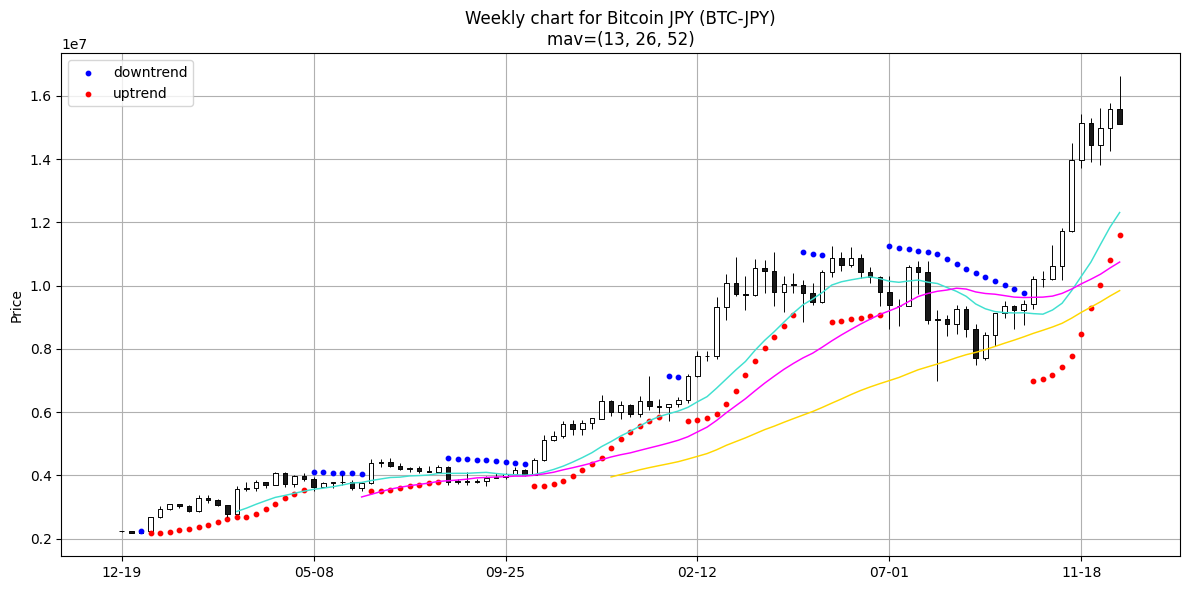

In [8]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(13, 26, 52),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Weekly chart for %s (%s)\nmav=(13, 26, 52)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Weekly chart for %s\nmav=(13, 26, 52)' % symbol)

ax.grid()
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('weekly_chart_exchange_psar.png')
plt.show()

In [12]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-12-16 00:00:00+00:00,16028582.0,16557646.0,15897460.0,16276849.0,14239908495360,0.0,0.0


In [13]:
df.tail(2)['Close']

Date
2024-12-09 00:00:00+00:00    15584573.0
2024-12-16 00:00:00+00:00    16276849.0
Name: Close, dtype: float64

In [14]:
df.tail(2)['Close'].diff()

Date
2024-12-09 00:00:00+00:00         NaN
2024-12-16 00:00:00+00:00    692276.0
Name: Close, dtype: float64

In [15]:
df['Close'].rolling(26).mean().tail(5)

Date
2024-11-18 00:00:00+00:00    1.005302e+07
2024-11-25 00:00:00+00:00    1.019909e+07
2024-12-02 00:00:00+00:00    1.035770e+07
2024-12-09 00:00:00+00:00    1.055631e+07
2024-12-16 00:00:00+00:00    1.078750e+07
Name: Close, dtype: float64

In [16]:
df['Close'].rolling(52).mean().tail(5)

Date
2024-11-18 00:00:00+00:00    9.152042e+06
2024-11-25 00:00:00+00:00    9.318361e+06
2024-12-02 00:00:00+00:00    9.484740e+06
2024-12-09 00:00:00+00:00    9.669002e+06
2024-12-16 00:00:00+00:00    9.862230e+06
Name: Close, dtype: float64